In [1]:
import pandas as pd
import numpy as np
import time as t
import datetime
import itertools
import os
from scipy.sparse import lil_matrix
import operator

In [2]:
# this is a numpy matrix of size (num_vertex, 3) which is the true positions in geographic space
location_array = np.array([[ 33.77636,  -84.397824],
                             [ 33.772428, -84.392709],
                             [ 33.77036,  -84.387824],
                             [ 33.765,    -84.38    ]])
# number of vertices
num_vertex = location_array.shape[0]

# this is a numpy matrix of size (num_vertex, num_vertex) which is populated by time between each location
original_adjacency_matrix = lil_matrix((num_vertex,num_vertex), dtype = np.float32)
original_adjacency_matrix[0,1] = 75
original_adjacency_matrix[1,0] = 75
original_adjacency_matrix[0,2] = 50
original_adjacency_matrix[2,0] = 50
original_adjacency_matrix.todense()

matrix([[ 0., 75., 50.,  0.],
        [75.,  0.,  0.,  0.],
        [50.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]], dtype=float32)

In [3]:
# convert adjacency_matrix to an initial "guess" at 3D coordinates. We want 3D coordinates to have minimal Z components
# please make Z = 0 for all points, and all x and y be seperated by average time difference (this is for mesh input)
# num_columns and num_rows are needed to know where everything is related to.

def initialize_coordinates(adjacency_matrix, num_rows, num_columns):
    # make coordinates matrix
    if num_rows * num_columns != adjacency_matrix.shape[0] or adjacency_matrix.shape[0] != adjacency_matrix.shape[1]:
        raise ValueError("Your dimensions are wrong! Get it together breh")
    
    coordinates = np.zeros(shape = (adjacency_matrix.shape[0], 3))
    cx = adjacency_matrix.tocoo()
    
    # find average time seperation
    weight = 0
    counter = 0
    for i,j,v in zip(cx.row, cx.col, cx.data):
        counter += 1
        weight += v
    avg = weight/counter
    
    # make mesh to find where each coordinate should begin
    mesh = np.zeros(shape = (num_rows, num_columns, 3))
    for i,j in itertools.product(range(num_rows), range(num_columns)):
        mesh[i,j,0] = i*avg
        mesh[i,j,1] = j*avg
    
    # set coordinates from mesh and return
    for i,j in itertools.product(range(num_rows), range(num_columns)):
        index = i * num_columns + j
        coordinates[index,:] = mesh[i,j,:]
    return coordinates

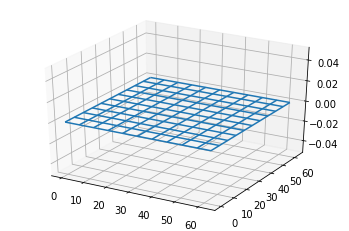

array([[ 0. ,  0. ,  0. ],
       [ 0. , 62.5,  0. ],
       [62.5,  0. ,  0. ],
       [62.5, 62.5,  0. ]])

In [7]:
coordinates = initialize_coordinates(original_adjacency_matrix, 2, 2)
plot_coordinates(coordinates)
coordinates

In [8]:
# convert our 3D coordinates into a matrix representation,
# where x and y and interpolated from their nearest locations as well as z

from scipy.interpolate import interp2d

def interpolate_mesh(coordinates, num_points= 100):
    # make f, our function which estimates the z or height at all positions
    f = interp2d(coordinates[:,0], coordinates[:,1], coordinates[:,2], kind='linear')
    
    # make the new mesh
    min_bounds = np.min(coordinates, axis = 0)
    max_bounds = np.max(coordinates, axis = 0)
    x_new = np.linspace(min_bounds[0], max_bounds[0], num=num_points)
    y_new = np.linspace(min_bounds[1], max_bounds[1], num=num_points)
    xx_new, yy_new = np.meshgrid(x_new, y_new)
    zz_new = f(x_new, y_new)
    
    arr = np.empty((num_points, num_points, 3))
    arr[:,:,0] = xx_new
    arr[:,:,1] = yy_new
    arr[:,:,2] = zz_new
    return arr

In [9]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

def plot_coordinates(coordinates,rstride=10, cstride=10):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    arr = interpolate_mesh(coordinates)
    X = arr[:,:,0]
    Y = arr[:,:,1]
    Z = arr[:,:,2]
    
    # Plot a basic wireframe.
    ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)
    
    # Plot the points on top of this
    #ax.scatter(coordinates[:,0], coordinates[:,1], coordinates[:,2])
    plt.show()

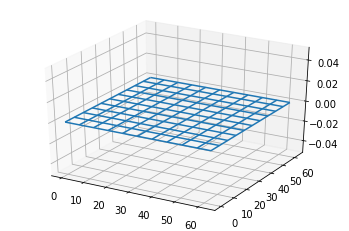

In [10]:
plot_coordinates(coordinates)

In [11]:
# take 3D coordinates and original adjacency_matrix and return RMSE 
def rmse(coordinates, adjacency_matrix):
    RMSE = 0
    # create a counter to see how many values we're comparing
    counter = 0
    # find the points in the adjacency matrix that are not 0
    cx = adjacency_matrix.tocoo()
    for i,j,v in zip(cx.row, cx.col, cx.data):
        # get the cooresponding points from the coordinate matrix
        pt_one = coordinates[i]
        pt_two = coordinates[j]
        # for that data point, calculate the given time between them with the coordinates
        # for example, if there is 9 at (2,1), we will use the distance formula on coordinate 2
        # and coordinate 1 of the coordinate matrix
        distance = ((pt_one[0] - pt_two[0])**2 + (pt_one[1] - pt_two[1])**2 + (pt_one[2] - pt_two[2])**2)**.5
        # then, find the RMSE of the predicted point (coordinate) and the given point (adjacency)
        true_dist = v
        RMSE += (distance - true_dist)**2
        counter += 1
    RMSE = (RMSE/counter)**.5
    return RMSE

In [12]:
rmse_curr = rmse(coordinates, original_adjacency_matrix)
rmse_curr

12.5

In [13]:
# take 3D coordinates and original adjacency_matrix and return new adjacency_matrix

def coordinates_adjacency(coordinates, original_adjacency_matrix):
    adjacency_matrix = lil_matrix(original_adjacency_matrix.shape, dtype = np.float32)
    cx = original_adjacency_matrix.tocoo()
    for i,j in zip(cx.row, cx.col):
        pt_one = coordinates[i]
        pt_two = coordinates[j]
        distance = ((pt_one[0] - pt_two[0])**2 + (pt_one[1] - pt_two[1])**2 + (pt_one[2] - pt_two[2])**2)**.5
        adjacency_matrix[i,j] = distance
    return adjacency_matrix

In [14]:
new_adjacency_matrix = coordinates_adjacency(coordinates, original_adjacency_matrix)
new_adjacency_matrix.todense()

matrix([[ 0. , 62.5, 62.5,  0. ],
        [62.5,  0. ,  0. ,  0. ],
        [62.5,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ]], dtype=float32)

turns out for our particular problem we are trying to minimize the following equation:

V is the set of coordinate points
$N_{pi}$ is the neighborhood for a specific coordinate point $p_{i}$
A is the QUERIED or TRUE adjacency matrix we wish to emulate without solution

$\sqrt{\Sigma_{p_{i}}^{V}\Sigma_{n_{j}}^{N_{pi}}(\sqrt{\Sigma(p_{i} - n_{j})^2} - A[n_j,p_i])^2}/\sqrt{\text{num vertex}}$

The "english" version of this is the minimal root mean squared error between our distance and the true distance. The term below is simply the distance equation between a point and its neighbors.

$\sqrt{\Sigma(p_{i} - n_{j})^2}$

Using A' to represent the Ajacency Matrix we calculate above (i.e. from our current coordinates),
the above can be written quite simply as:

$\sqrt{\Sigma_{p_{i}}^{V}\Sigma_{n_{j}}^{N_{pi}}(A'[i,j]-A[i,j])^2}/\sqrt{\text{num vertex}}$

or even more simply,

$\sqrt{\Sigma_{i,j}^{A}(A'[i,j]-A[i,j])^2}/\sqrt{\text{num vertex}}$

why not again?

$RMSE(A',A)$


This above equation can be minimized by changing where each coordinate lies. In the sgd function below, we are simply calculating an analytical approx. for the gradient for each point in turn, and then updating each point by some learning rate.
***A key efficiency consideration would be to not calulate change in RMSE using all points as RMSE by changing one point only effects the neighbors of this point***

Another option to find ideal coordinate positions would be to analytically/explicity solve the above equation. This would be done by taking the partial derivative with respect to every xyz coordinates, finding where the gradient is 0 and being finished. Unfortunately, this solvation is not convex (i.e. only one minimum) if we look at RMSE(A',A), ***but to find x,y,z that minimizes RMSE(A'A) by changing only one point is actually convex.*** I will prove this below, its not super involved math but if it scares you feel free to ignore it. Basically what this equation gives us is a way to calculate the best position to put a x,y,x coordinate to minimize RMSE by only changing that coordinate.

minimize: 

$\sqrt{\Sigma_{p_{i}}^{V}\Sigma_{n_{j}}^{N_{pi}}(\sqrt{\Sigma(p_{i} - n_{j})^2} - A[n_j,p_i])^2}/\sqrt{\text{num vertex}}$

look at minimizing RMSE for one point (i), we can ignore the num vertex as it is a constant, and the square root is actually also unneeded, as the absolute minima for MSE is also the absolute minima for RMSE:

$\Sigma_{j}^{N_{i}}(\sqrt{\Sigma(p_{i} - n_{j})^2} - A[n_j,p_i])^2$

now take the derivative with respect to x

$\Sigma_{j}^{N_{i}}2(\sqrt{\Sigma(p_{i} - n_{j})^2} - A[n_j,p_i])$


In [15]:
# turns our for our particular problem we are trying to minimize the following equation, which sh

def explicit_solvation(coordinates, adjacency_matrix):
    raise ValueError()

In [16]:
# Simplified RMSE difference between initial and final to make the process computationally easier for calculating partial derivatives 
def RMSEdiff(coordinates, adjacency_matrix, vertex_index, delta, xyz_index):
    
    cx = adjacency_matrix.getrowview(vertex_index).tocoo()
    RMSEinitial = 0
    RMSEdiff = 0
    counter = 0
    deltaX = 0
    deltaY = 0
    deltaZ = 0
    
    # xyz_index is the index of whatever value needs to be changed
    if(xyz_index == 0):
        deltaX = delta
    elif(xyz_index == 1):
        deltaY = delta
    elif(xyz_index == 2):
        deltaZ = delta
    
    for row,col,data in zip(cx.row, cx.col, cx.data):
        # find the distance between the two coordinates, as well as the distance if the delta changes x, y, or z
        distanceinitial = ((coordinates[col, 0] - coordinates[row, 0])**2
                            + (coordinates[col, 1] - coordinates[row, 1])**2
                            + (coordinates[col, 2] - coordinates[row, 2])**2) **.5
        
        distancewithdelta = ((coordinates[col, 0] - (coordinates[row, 0] + deltaX))**2
                            + (coordinates[col, 1] - (coordinates[row, 1] + deltaY))**2
                            + (coordinates[col, 2] - (coordinates[row, 2] + deltaZ))**2) ** .5
        
        #print(distancewithdelta, distanceinitial)
        # then, find the RMSE of the predicted point (coordinate) and the given point (adjacency) for both the initial and final
        RMSEinitial += (distanceinitial - data)**2
        RMSEdiff += (distancewithdelta - data)**2
        counter += 1
    
    if counter != 0:
        ret_val = ((RMSEdiff-RMSEinitial)/counter)
        return ret_val
    else:
        return 0


In [17]:
# take 3D coordinates and return updated 3D coordinates using SGD
# coordinates is a nx3 numpy array
# adjacency_matrix is a nxn lil matrix

def sgd(coordinates, adjacency_matrix, delta = 1e-3, alpha = 1e-5):
    new_coordinates = np.copy(coordinates)
    # Alpha + Delta are Hyperparameters (ones that you can change)
    alpha = 0.01
    # Not sure if #1, deltas should be different, and #2, if they should gradually become lower
    # this can be played around with
    deltaX = delta
    deltaY = delta
    deltaZ = delta
    # main iterator that goes through each point updating their x, y, and z value
    for vertex_index in range(coordinates.shape[0]):
        new_coordinates[vertex_index, 0] -= (alpha/delta * (RMSEdiff(new_coordinates,
                                                               adjacency_matrix, vertex_index, deltaX, 0)))
        new_coordinates[vertex_index, 1] -= (alpha/delta * (RMSEdiff(new_coordinates,
                                                               adjacency_matrix, vertex_index, deltaY, 1)))
        new_coordinates[vertex_index, 2] -= (alpha/delta * (RMSEdiff(new_coordinates,
                                                               adjacency_matrix, vertex_index, deltaZ, 2)))
    # Not sure if we want to recreate new coordinates
    return new_coordinates

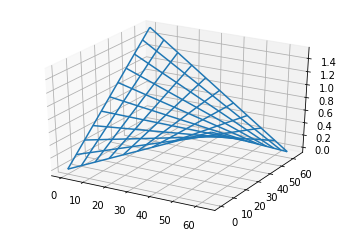

In [19]:
new_coordinates = sgd(coordinates, original_adjacency_matrix)
new_coordinates
plot_coordinates(new_coordinates)

In [20]:
# run full simulation and return lists of coordinates and rmse

def simulation(adjacency_matrix, num_rows, num_columns, num_iterations = 1e4, delta = 1e-3, alpha = 1e-5):
    
    coordinates_ls, rmse_ls = [], []
    
    # initialize coordinates and rmse
    coordinates_ls.append(initialize_coordinates(adjacency_matrix,num_rows,num_columns))
    rmse_ls.append(rmse(coordinates_ls[-1], adjacency_matrix))
    
    # continue to add coordinates and rmse
    for i in range(int(num_iterations)):
        if i % 100 == 0:
            plot_coordinates(coordinates_ls[-1], rstride=100, cstride=100)
            print(rmse_ls[-1])
        
        coordinates_ls.append(sgd(coordinates_ls[-1], adjacency_matrix, delta = 1e-3, alpha = 1e-5))
        rmse_ls.append(rmse(coordinates_ls[-1], adjacency_matrix))
    
    return coordinates_ls, rmse_ls

In [21]:
# dump the simulation into a pandas df and then a csv (not done yet)

coordinates_ls, rmse_ls = simulation(adjacency_matrix, 2, 2, num_iterations = 1e4)

d = {"rmse":1,
    "x":2,
    "y":3,
    "z":4}

df = pd.DataFrame(d)
path = os.path.join(os.getcwd(), "..")
path = os.path.join(path, "dataset")
path = os.path.join(path, "simulation.csv")
df.to_csv(path)

NameError: name 'adjacency_matrix' is not defined

In [22]:
# now we will try it on our data!!

def csv_graph(csv, value = "Traffic Time"):
    
    df = pd.read_csv(csv)
    
    locations = set()
    for row in range(df.shape[0]):
        loc = tuple([df["Origin Latitude"][row],df["Origin Longitude"][row]])
        locations.add(loc)
    locations = list(locations)
    
    num_vertex = len(locations)
    location_array = np.zeros(shape = (num_vertex, 2))
    adjacency_matrix = lil_matrix((num_vertex,num_vertex), dtype = np.float32)

    locations.sort(key = operator.itemgetter(0, 1))
    for i in range(len(locations)):
        location_array[i,0] = locations[i][0]
        location_array[i,1] = locations[i][1]
        
    for row in range(df.shape[0]):
        loc_1 = tuple([df["Origin Latitude"][row],df["Origin Longitude"][row]])
        loc_2 = tuple([df["Destination Latitude"][row],df["Destination Longitude"][row]])
        i = np.where((location_array == loc_1).all(axis=1))[0][0]
        j = np.where((location_array == loc_2).all(axis=1))[0][0]
        val = df[value][row]
        adjacency_matrix[i,j] = df[value][row]
        
    return location_array, adjacency_matrix

In [23]:
location_array, adjacency_matrix = csv_graph("../dataset/dataset.csv")
rows = 0
val = location_array[rows,0]
while location_array[rows,0] == val:
    val = location_array[rows,0]
    rows += 1

cols = int(location_array.shape[0]/rows)

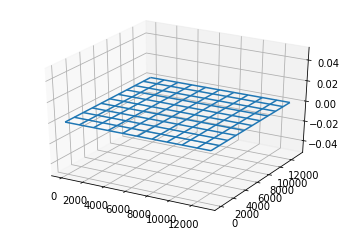

524.5937226150662


C:\Users\Owner\Anaconda3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the additional knot would
coincide with an old one. Probable cause: s too small or too large
a weight to an inaccurate data point. (fp>s)
	kx,ky=1,1 nx,ny=4,4 m=400 fp=494768.855442 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


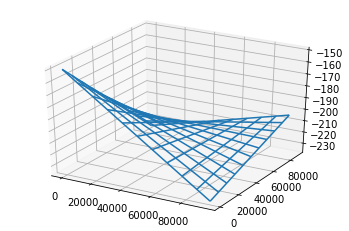

4046.6337359480294


C:\Users\Owner\Anaconda3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the additional knot would
coincide with an old one. Probable cause: s too small or too large
a weight to an inaccurate data point. (fp>s)
	kx,ky=1,1 nx,ny=4,4 m=400 fp=27892582.025607 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


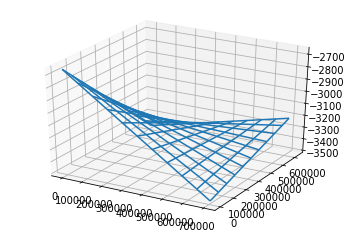

32083.78956435769


In [25]:
coordinates_ls, rmse_ls = simulation(adjacency_matrix, rows, cols, num_iterations = 3e2, delta = 1, alpha = 1e-8)

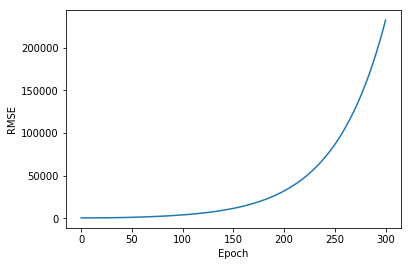

In [26]:
plt.plot(list(range(len(rmse_ls))), rmse_ls)
plt.ylabel("RMSE")
plt.xlabel("Epoch")
plt.show()